## [pyKNEEr](https://github.com/sbonaretti/pyKNEEr)

# [Preprocessing MR Knee Images](https://sbonaretti.github.io/pyKNEEr/preprocessing.html)

Preprocessing of MR images is fundamental to standardize spatial information and intensity of images

In the pipeline below:
- Steps 1-3 uniform image orientation, knee laterality, and image origin. The resulting image has the same intensity as the acquired `.dcm` image, but different collocation in space. It is saved as `_orig.mha`
- Steps 4-6 act on the intensities of the image, by correcting the inhomogeneous magnetic field, rescaling to a fixed range, and enhancing the cartilage contours [1]. The resulting image has different intensity than the acquired `.dcm` image, and it is used for atlas-based segmentation. It is saved as `_prep.mha`. These steps are computationally expensive, so if not needed, avoid them by setting `intensity_standardization` to zero (see below) 

## Import packages

In [1]:
from pykneer import pykneer_io as io
from pykneer import preprocessing_for_nb as prep

## Image information

Inputs:   
- `input_file_name` contains the list of the images to be preprocessed 
- `nOfCores` is the number of cores used for computations (computations are parallelized for speed)
- `intensity_standardization` is a flag that determines if the intensity standardization is performed (0=no, 1=yes)

In [2]:
input_file_name           = "./image_list_preprocessing.txt"
n_of_cores                = 3
intensity_standardization = 1

#### Read image data
- `imageData` is a dictionary (or struct), where each cell corresponds to an image. For each image, information such as paths and file names are stored  

In [3]:
image_data = io.load_image_data_preprocessing(input_file_name)

01_DESS_01
01_DESS_02
01_cubeQuant_01
01_cubeQuant_02
01_cubeQuant_03
01_cubeQuant_04
-> information loaded for 6 subjects


## Spatial standardization

#### Step 0: Read the dicom images

In [4]:
prep.read_dicom_stack(image_data, n_of_cores)

-> 01_DESS_02
Size:      512   512   80
Spacing:   0.31 0.31 1.50
-> 01_DESS_01
Origin:    13.08 -68.36 79.84
Size:      512   512   80
Direction: 
-0.00 0.00 -1.00 
1.00 0.00 0.00 
0.00 -1.00 0.00Spacing:   0.31 0.31 1.50

Origin:    13.08 -68.36 79.84
-> 01_cubeQuant_01
Direction: 
-0.00 0.00 -1.00 
1.00 0.00 0.00 
0.00 -1.00 0.00Size:      512   512   80

Spacing:   0.31 0.31 1.50
Origin:    12.33 -68.36 79.84
Direction: 
-0.00 0.00 -1.00 
1.00 0.00 0.00 
0.00 -1.00 0.00
-> 01_cubeQuant_04
-> 01_cubeQuant_02
Size:      512   512   80
Size:      512   512   80
Spacing:   0.31 0.31 1.50
Origin:    12.33 -68.36 79.84
Direction: 
-0.00 0.00 -1.00 
1.00 0.00 0.00 
0.00 -1.00 0.00
Spacing:   0.31 0.31 1.50
Origin:    12.33 -68.36 79.84
Direction: 
-0.00 0.00 -1.00 
1.00 0.00 0.00 
0.00 -1.00 0.00
-> 01_cubeQuant_03
Size:      512   512   80
Spacing:   0.31 0.31 1.50
Origin:    12.33 -68.36 79.84
Direction: 
-0.00 0.00 -1.00 
1.00 0.00 0.00 
0.00 -1.00 0.00
-> Dicom images read
-> The tota

#####   Save image header
The image header of the first slice of the dicom stack is saved in a `.txt` file. This can be useful to extract information such as subject's date of birth, exam date, etc.

In [5]:
prep.print_dicom_header(image_data, n_of_cores)

-> Dicom headers written
-> The total time was 0.62 seconds (about 0 min)


#### Step 1: Change orientation to RAI 
All images are oriented to the RAI (right, anterior, inferior) orientation

In [6]:
prep.orientation_to_rai(image_data, n_of_cores)

-> Image orientation changed
-> The total time was 4.87 seconds (about 0 min)


#### Step 2: Change laterality if knee is right
Right knees are flipped to left knees to have the same laterality 

In [7]:
prep.flip_rl(image_data, n_of_cores)

-> Image laterality changed for right images
-> The total time was 0.53 seconds (about 0 min)


#### 3. Set image origin to (0,0,0)
All images are set to the origin (0,0,0). Images are saved as *_orig.mha and they are anonymized

In [8]:
prep.origin_to_zero(image_data, n_of_cores)

-> Image origin changed
-> _orig.mha images saved
-> The total time was 0.61 seconds (about 0 min)


#### 4. Correct magnetic field inhomogeneities
Magnetic fields inhomogeneities create grey shades on images. This correction removes these shades. This is the longest step of the processing. It can take up to 15-20 min on a standard PC or laptop

In [9]:
if intensity_standardization == 1:
    prep.field_correction(image_data, n_of_cores) 

-> The total time for image 01_DESS_02 was 1343 seconds (about 22 min)
-> The total time for image 01_cubeQuant_01 was 1345 seconds (about 22 min)
-> The total time for image 01_DESS_01 was 1569 seconds (about 26 min)
-> The total time for image 01_cubeQuant_04 was 978 seconds (about 16 min)
-> The total time for image 01_cubeQuant_02 was 1380 seconds (about 23 min)
-> The total time for image 01_cubeQuant_03 was 1429 seconds (about 23 min)
-> Magnetic field bias corrected
-> The total time was 2774.85 seconds (about 46 min)


#### 5. Rescale intensities to [0 100]
Intensies are rescaled to the fixed range [0,100] to obtain homogeneous intensity range across images

In [10]:
if intensity_standardization == 1:
    prep.rescale_to_range(image_data, n_of_cores) 

-> Image intensities rescaled
-> The total time was 2.88 seconds (about 0 min)


#### 6. Edge preserving smoothing
Cartilage contours are enhanced using a curvature anisotropic diffusion filter

In [11]:
if intensity_standardization == 1:
    prep.edge_preserving_smoothing(image_data, n_of_cores) 

-> Image smoothed
-> _prep.mha images saved
-> The total time was 120.98 seconds (about 2 min)


## Visualize original and preprocessed image
Each row corresponds to one image. Left: Original image after spatial preprocessing (steps 1-3). Right: Preprocessed image after intensities correction (steps 4-6). 
Note: A total black rendering of an original image is caused by very large intensity distribution

<Figure size 576x1728 with 0 Axes>

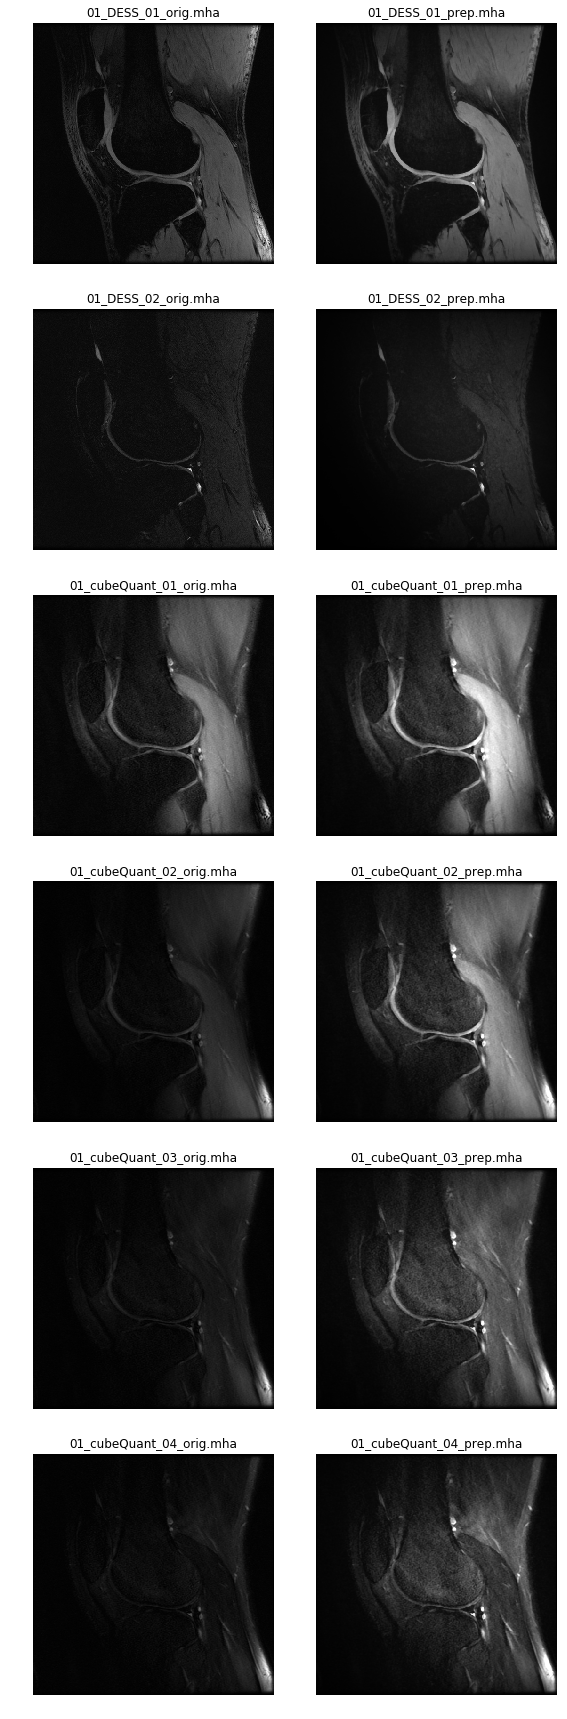

In [12]:
prep.show_preprocessed_images(image_data, intensity_standardization)

### References

[1] Shan L., Zach C., Charles C., Niethammer M. [*Automatic Atlas-Based Three-Label Cartilage Segmentation from MR Knee Images.*](https://www.ncbi.nlm.nih.gov/pubmed/25128683) Med Image Anal. Oct;18(7):1233-46. 2014.

### Dependencies

In [13]:
%load_ext watermark
%watermark -v -m -p SimpleITK,ikt,numpy,matplotlib,multiprocessing

CPython 3.7.1
IPython 7.2.0

SimpleITK unknown
ikt not installed
numpy 1.16.1
matplotlib 2.2.3
multiprocessing unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
